In [1]:
%autosave 60

Autosaving every 60 seconds


### Импорт библиотек

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk

from phik import phik_matrix

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool

import optuna
import shap

from IPython.display import Image, display
from datetime import datetime

In [3]:
plt.style.use('cyberpunk')

# МТС ШАД ДЗ ML 2
---

## Intro

Ник на Kaggle: **KsyLight** <br>
Итоговая позиция: **1**

### Скрины

**Результат в контесте**

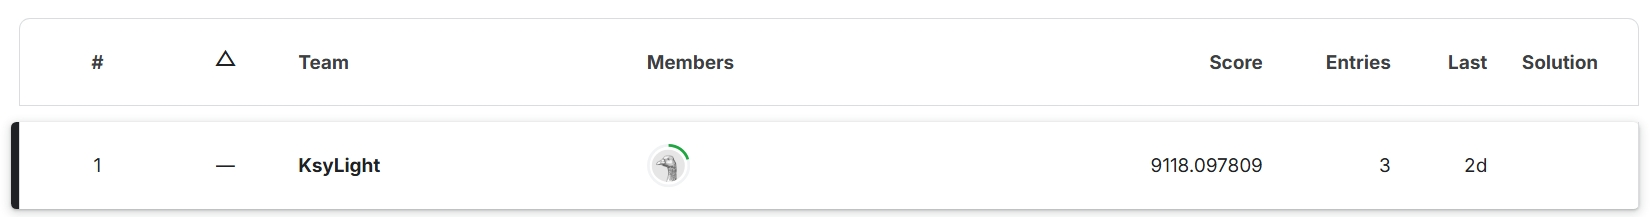

In [4]:
display(Image(filename="photo1.jpeg"))

**Это сабмит уже после завершения, но с самыми оптимальными гиперпараметрами из 30 итераций с помощью `Oprtuna`**

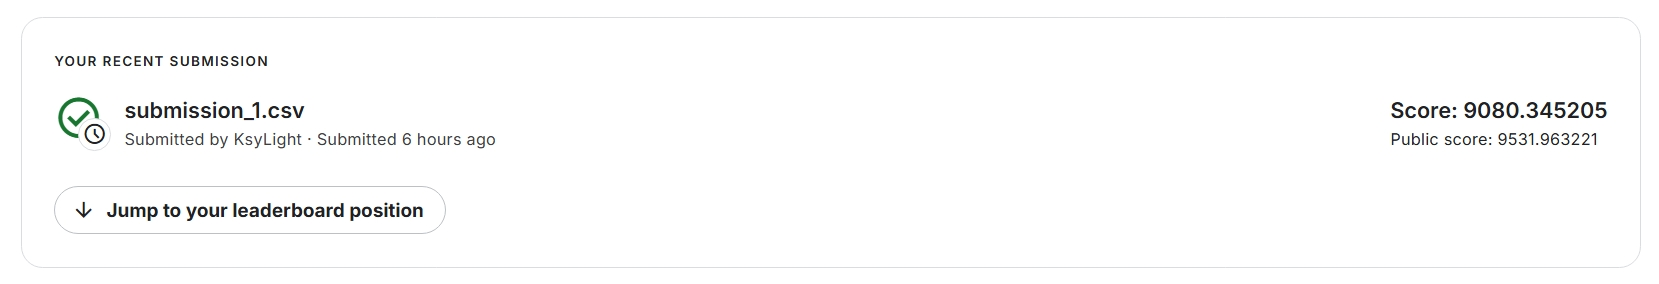

In [5]:
display(Image(filename="photo2.jpeg"))

**Ну и просто все сабмиты - не знаю, зачем : )**

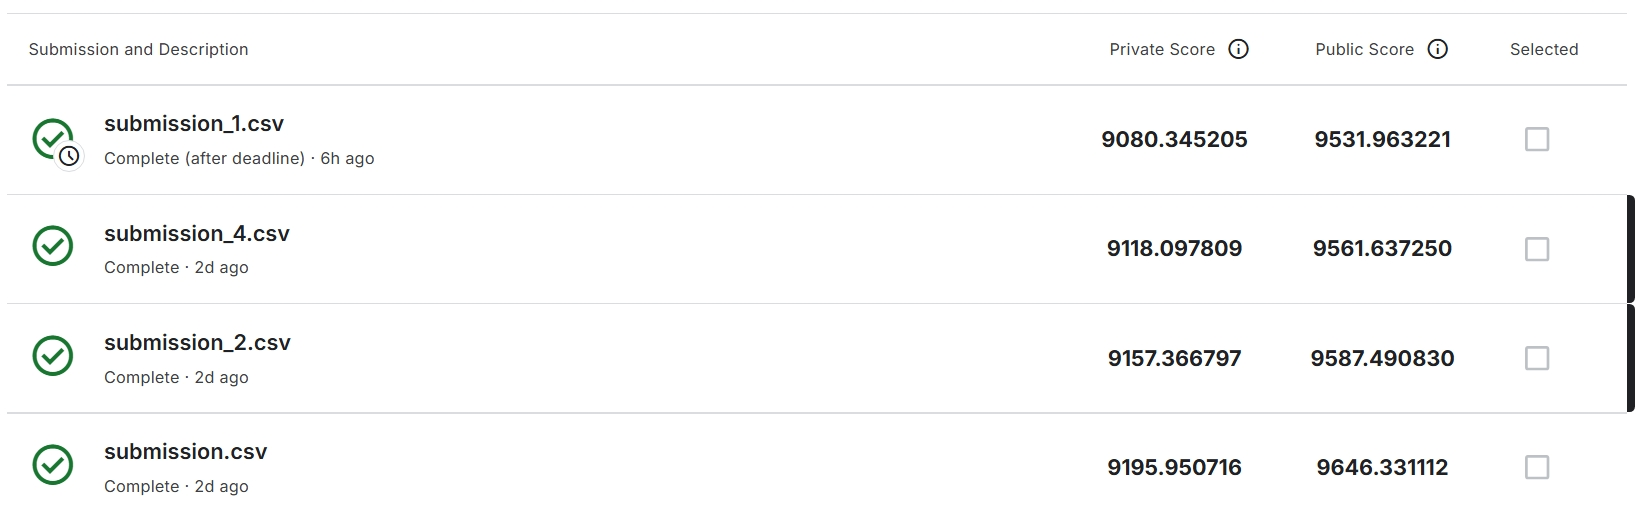

In [6]:
display(Image(filename="photo3.jpeg"))

Теперь перейду к делу

Цель проекта — построение модели регрессии для предсказания значения целевой переменной `target` на основе различных признаков, описывающих объект (например, активность хоста, параметры размещения, историю отзывов и т.д.).

**1. Как обработали данные:**
- Признак `last_dt` преобразован в datetime, из него извлечены компоненты: `last_year`, `last_month`, `last_day`, `last_weekday`.
- Создан бинарный признак `is_missing_last_dt`, отражающий наличие пропущенных значений в дате. Он, правда, оказался бесполезен.
- Удалён неинформативный текстовый признак `name`.
- Категориальные признаки (`host_name`, `type_house`, `location_cluster`) передавались в модель напрямую.


**2. Какой алгоритм выбрали:**
- Выбран алгоритм **CatBoostRegressor** — бустинг на деревьях решений, подходящий для работы с категориальными и пропущенными значениями без дополнительной подготовки.
- В качестве функции потерь использовалась RMSE (корень из среднеквадратичной ошибки), поскольку она выражается в тех же единицах, что и целевая переменная, и, таким образом, лучше интерпретируется с прикладной точки зрения. По сути, RMSE — это MSE, приведённая к масштабу исходных данных, поэтому они минимизируют одну и ту же ошибку, но RMSE более понятна при анализе результатов. Хотя это и так понятно : )

**3. Особенности обучения:**
- Были обучены модели с различными конфигурациями гиперпараметров (`model_final`, `model_final_1`, `model_final_2`, `model_final_3`).
- Подбор гиперпараметров проводился с помощью библиотеки `Optuna`, за исключением модели `model_final`.
- Для оценки качества использовалась пользовательская функция `evaluate_model()` с выводом метрик RMSE, MSE и R², а также графиков: предсказания vs реальные значения, остатки, Q-Q plot.

**4. Как проводилась валидация алгоритма:**
- Использовано разбиение через `train_test_split` (`test_size=0.2`, `random_state=42`).
- Сравнение моделей производилось на валидационной выборке по метрикам RMSE, MSE и R².
- Для анализа недо- и переобучения построены графики остатков и Q-Q plot.
- Также был проведён анализ важности признаков с помощью SHAP-графиков (bar и dot plot).

### Загрузка датасетов

In [7]:
df_2 = pd.read_csv('test.csv')
df_1 = pd.read_csv('train.csv')
sample_submition = pd.read_csv('sample_submition.csv')

---
## EDA-анализ

### Общая информация

In [8]:
display(sample_submition.sample(5))

,index,prediction
1366,1366,112.825425
9843,9843,112.825425
9023,9023,112.825425
497,497,112.825425
7565,7565,112.825425


In [9]:
datasets = [df_1, df_2]

In [10]:
for dataset in datasets:
    display(dataset.head(3))

,name,_id,host_name,location_cluster,location,lat,lon,type_house,sum,min_days,amt_reviews,last_dt,avg_reviews,total_host,target
0,Belle Harbor 4 BR 2 bath- 1 bl from Beach,40327248,Sarina,Queens,Neponsit,40.57215,-73.85822,Entire home/apt,350,2,5,2019-07-07,2.88,1,334
1,"Come see Brooklyn, New York",13617520,Howard T.,Brooklyn,Clinton Hill,40.69172,-73.96934,Shared room,40,5,8,2015-02-25,0.13,1,0
2,Large 2Br on W71st & Columbus Feb 19-28,26754726,Julie,Manhattan,Upper West Side,40.77673,-73.98011,Entire home/apt,200,5,0,NaN,NaN,1,0


,name,_id,host_name,location_cluster,location,lat,lon,type_house,sum,min_days,amt_reviews,last_dt,avg_reviews,total_host
0,Amazing 4 Bedrooms 4 Bathrooms sleeps 9,199147185,Lou,Brooklyn,Sunset Park,40.66468,-73.99785,Entire home/apt,399,1,0,NaN,NaN,5
1,Super Spacious room in Brooklyn,259427246,Nelly,Brooklyn,Bedford-Stuyvesant,40.67880,-73.92722,Private room,43,1,4,2019-06-10,2.00,3
2,Stunning 1-Bedroom NYC Apartment on the River!,30283594,Kara,Manhattan,Hell's Kitchen,40.76170,-73.99762,Entire home/apt,275,30,2,2017-09-17,0.08,121


In [11]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36671 entries, 0 to 36670
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              36662 non-null  object 
 1   _id               36671 non-null  int64  
 2   host_name         36653 non-null  object 
 3   location_cluster  36671 non-null  object 
 4   location          36671 non-null  object 
 5   lat               36671 non-null  float64
 6   lon               36671 non-null  float64
 7   type_house        36671 non-null  object 
 8   sum               36671 non-null  int64  
 9   min_days          36671 non-null  int64  
 10  amt_reviews       36671 non-null  int64  
 11  last_dt           29169 non-null  object 
 12  avg_reviews       29169 non-null  float64
 13  total_host        36671 non-null  int64  
 14  target            36671 non-null  int64  
dtypes: float64(3), int64(6), object(6)
memory usage: 4.2+ MB


### Пропуски и дубликаты

In [12]:
for dataset in datasets:
    print("Количество пропусков в абсолютных и относительных значениях:")
    display(pd.DataFrame({
    'Total NaN': dataset.isna().sum(),
    'Percentage NaN': dataset.isna().mean() * 100
    }).style.background_gradient('coolwarm').format({'Percentage NaN': '{:.2f}%'}))

Количество пропусков в абсолютных и относительных значениях:


,Total NaN,Percentage NaN
name,9,0.02%
_id,0,0.00%
host_name,18,0.05%
location_cluster,0,0.00%
location,0,0.00%
lat,0,0.00%
lon,0,0.00%
type_house,0,0.00%
sum,0,0.00%
min_days,0,0.00%


Количество пропусков в абсолютных и относительных значениях:


,Total NaN,Percentage NaN
name,7,0.06%
_id,0,0.00%
host_name,3,0.02%
location_cluster,0,0.00%
location,0,0.00%
lat,0,0.00%
lon,0,0.00%
type_house,0,0.00%
sum,0,0.00%
min_days,0,0.00%


In [13]:
df_1.duplicated().sum()

0

### Распределения числовых признаков

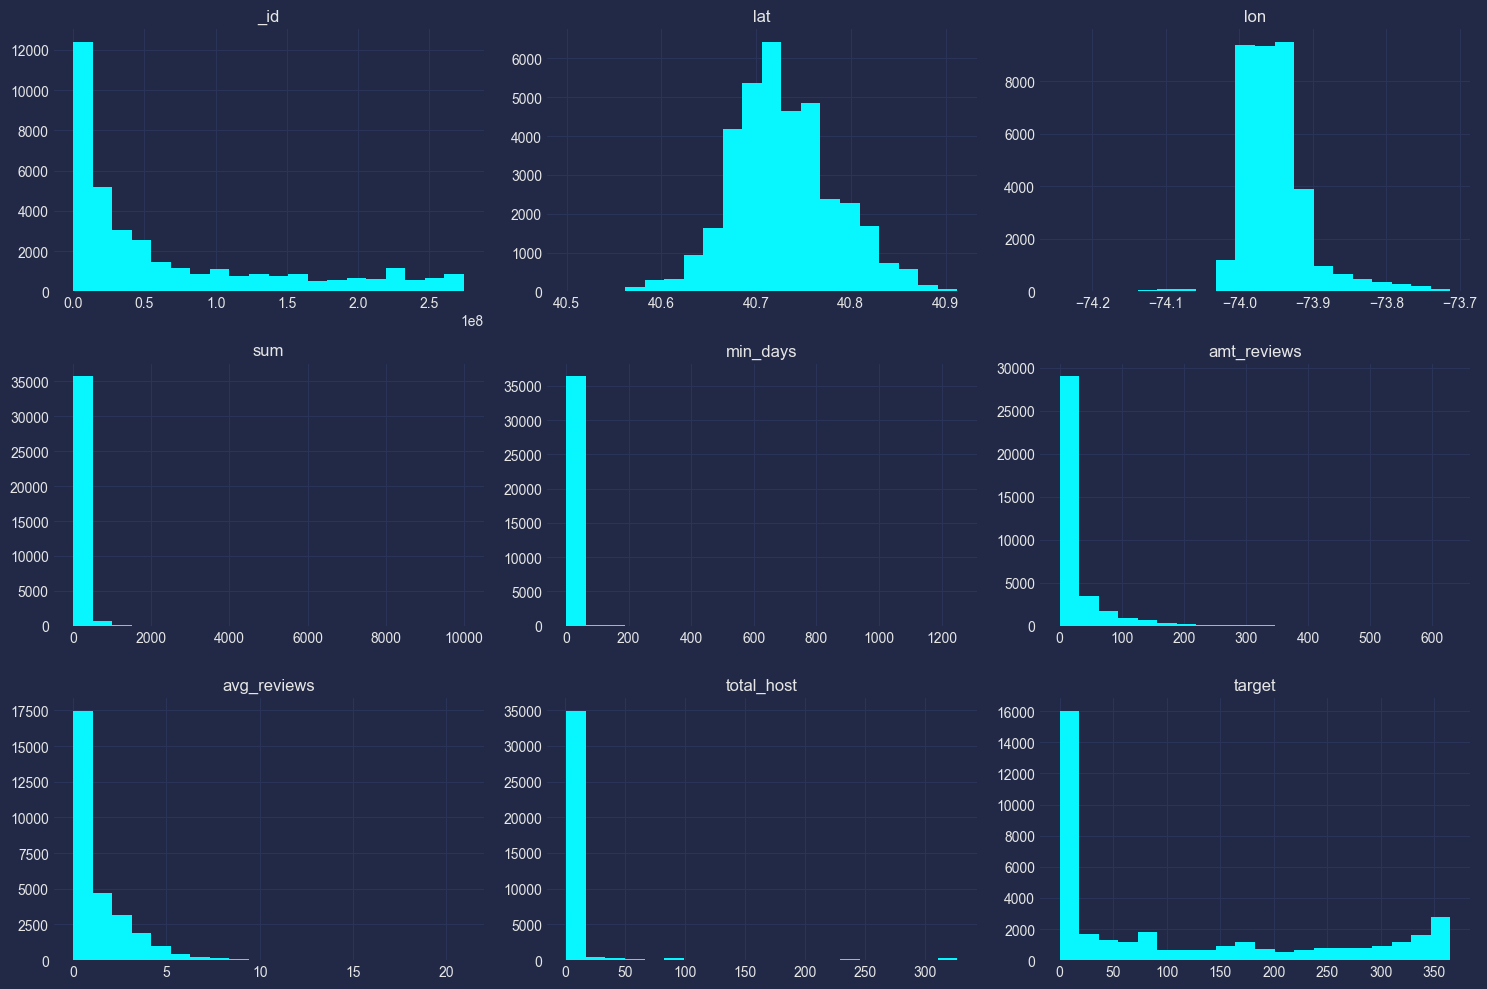

In [14]:
num_cols = df_1.select_dtypes(include=['int64', 'float64']).columns
df_1[num_cols].hist(figsize=(15, 10), bins=20)
plt.tight_layout()
plt.show()

### Уникальные значения в признаках

In [15]:
df_1['last_dt'] = pd.to_datetime(df_1['last_dt'])
categorical_cols = df_1.select_dtypes(include='object').columns.tolist()

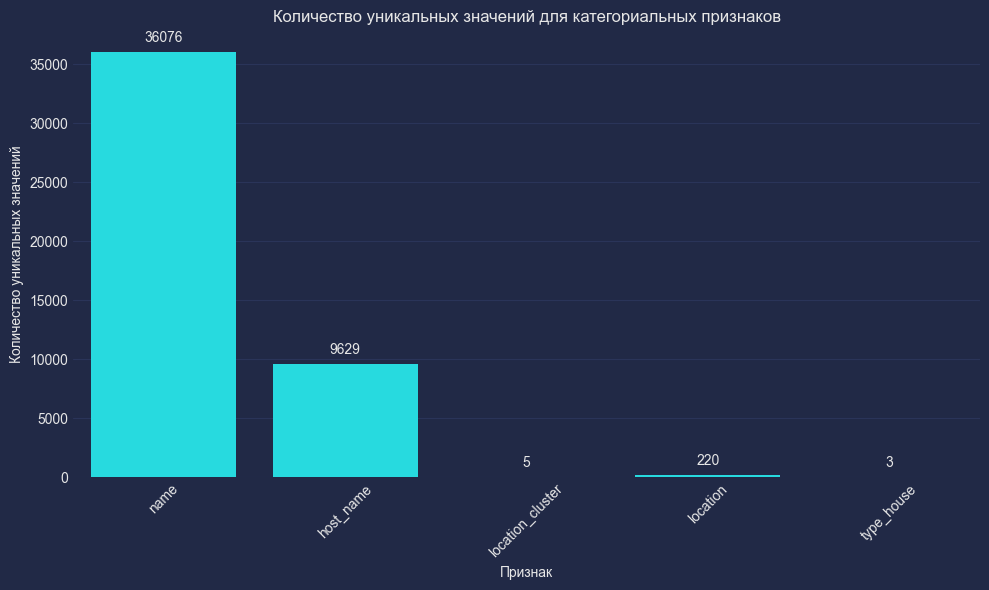

In [16]:
# Для каждого категориального признака считаем количество уникальных значений
cardinality = pd.DataFrame({
    'feature': categorical_cols,
    'nunique': [df_1[col].nunique() for col in categorical_cols]
})

# Визуализируем с помощью bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='feature', y='nunique', data=cardinality)

# Добавляем подписи с количеством уникальных значений над каждым столбцом
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', 
                xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=45)
plt.title("Количество уникальных значений для категориальных признаков")
plt.xlabel("Признак")
plt.ylabel("Количество уникальных значений")
plt.tight_layout()
plt.show()

In [17]:
threshold = 100

high_cardinality_cols = []
for col in categorical_cols:
    num_unique = df_1[col].nunique()
    if num_unique > threshold:
        high_cardinality_cols.append(col)
        print(f"Признак '{col}' имеет {num_unique} уникальных значений (высокая кардинальность).")

Признак 'name' имеет 36076 уникальных значений (высокая кардинальность).
Признак 'host_name' имеет 9629 уникальных значений (высокая кардинальность).
Признак 'location' имеет 220 уникальных значений (высокая кардинальность).


In [18]:
high_cardinality_cols

['name', 'host_name', 'location']

### Матрицы корреляций

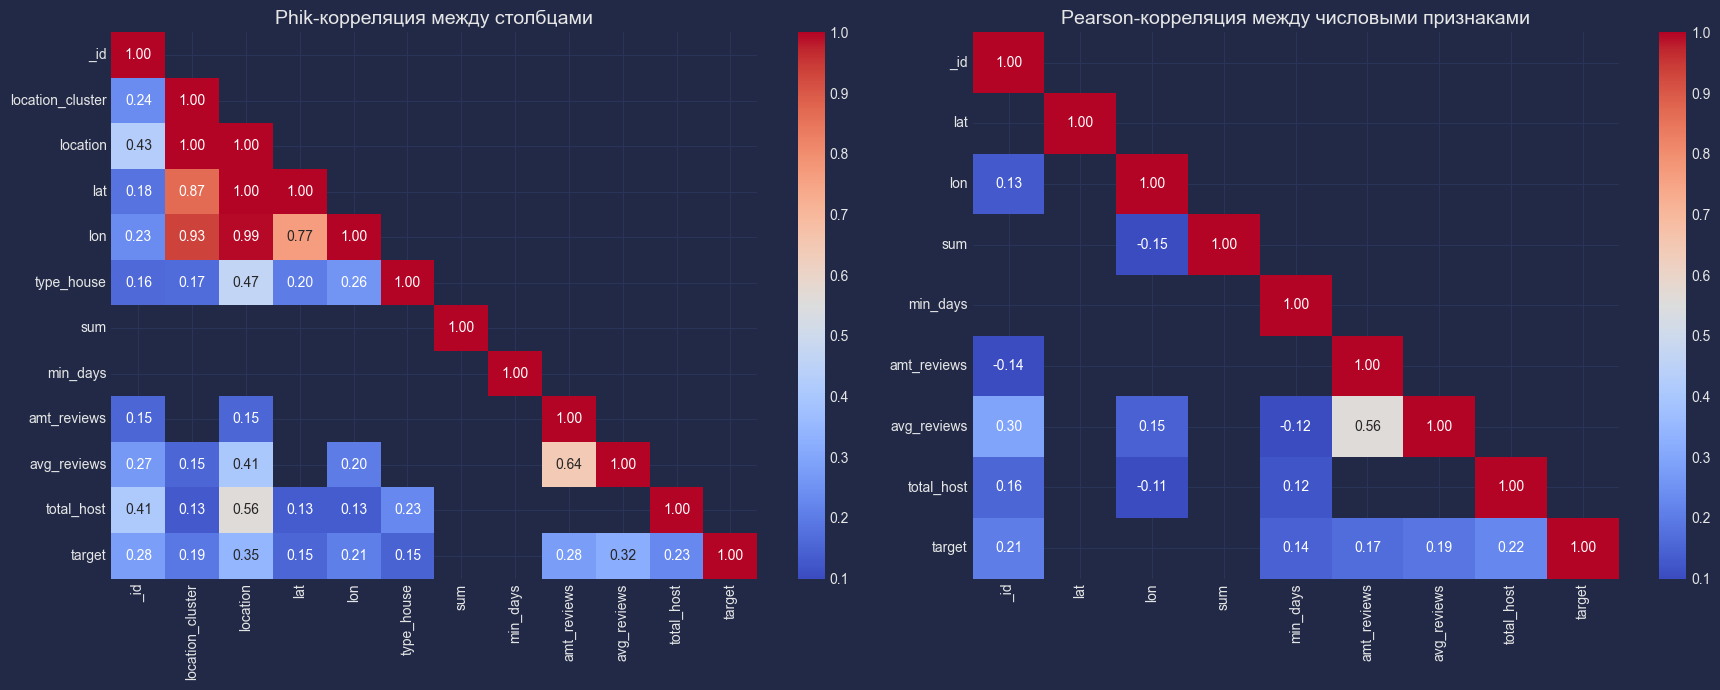

In [19]:
# Указываем интервальные (числовые) признаки
interval_cols = ['_id', 'lat', 'lon', 'sum', 'min_days', 'amt_reviews', 'avg_reviews', 'total_host', 'target']

# Исключаем признаки с очень большим числом уникальных значений (если нужно)
exclude_cols = ['name', 'host_name', 'last_dt']  # чтобы ускорить phik и избежать warning'ов
df_phik = df_1.drop(columns=exclude_cols, errors='ignore')

# PHIK корреляция
phik_corr = df_phik.phik_matrix(interval_cols=interval_cols)

# Маска и фильтрация слабых значений
mask_phik = np.triu(np.ones_like(phik_corr, dtype=bool), k=1)
phik_corr_filtered = phik_corr.copy()
phik_corr_filtered[phik_corr_filtered < 0.1] = np.nan

# Pearson корреляция для числовых признаков
num_cols = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr = df_1[num_cols].corr(method='pearson')

mask_pearson = np.triu(np.ones_like(corr, dtype=bool), k=1)
corr_filtered = corr.copy()
corr_filtered[corr_filtered.abs() < 0.1] = np.nan

# Построение двух тепловых карт рядом
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Левая — Phik
sns.heatmap(phik_corr_filtered, mask=mask_phik, annot=True, fmt='.2f',
            cmap='coolwarm', vmin=0.1, vmax=1, ax=axes[0])
axes[0].set_title("Phik-корреляция между столбцами", fontsize=14)

# Правая — Pearson
sns.heatmap(corr_filtered, mask=mask_pearson, annot=True, fmt='.2f',
            cmap='coolwarm', vmin=0.1, vmax=1, ax=axes[1])
axes[1].set_title("Pearson-корреляция между числовыми признаками", fontsize=14)

plt.tight_layout()
plt.show()

---
## Подготовка данных

In [20]:
train = df_1.copy()
test = df_2.copy()

### Обработка `train`

In [21]:
train.drop(columns=['name'], inplace=True, errors='ignore')

train['is_missing_last_dt'] = train['last_dt'].isna().astype(int)
train['last_dt'] = pd.to_datetime(train['last_dt'], errors='coerce')
train['last_year'] = train['last_dt'].dt.year
train['last_month'] = train['last_dt'].dt.month
train['last_day'] = train['last_dt'].dt.day
train['last_weekday'] = train['last_dt'].dt.weekday
train.drop(columns=['last_dt'], inplace=True, errors='ignore')

train['is_missing_avg_reviews'] = train['avg_reviews'].isna().astype(int)

train['host_name'] = train['host_name'].fillna('Unknown_host')

### Обработка `test`

In [22]:
test.drop(columns=['name'], inplace=True, errors='ignore')

test['is_missing_last_dt'] = test['last_dt'].isna().astype(int)
test['last_dt'] = pd.to_datetime(test['last_dt'], errors='coerce')
test['last_year'] = test['last_dt'].dt.year
test['last_month'] = test['last_dt'].dt.month
test['last_day'] = test['last_dt'].dt.day
test['last_weekday'] = test['last_dt'].dt.weekday
test.drop(columns=['last_dt'], inplace=True, errors='ignore')

test['is_missing_avg_reviews'] = test['avg_reviews'].isna().astype(int)

test['host_name'] = test['host_name'].fillna('Unknown_host')

## Обучение модели

### Предобработка признаков и разделение выборки для валидации

In [23]:
y = train['target']
X = train.drop('target', axis=1)

cat_features = [col for col in X.columns if X[col].dtype == 'object']
cat_features += ['location_cluster', 'type_house']
cat_features = list(set(cat_features).intersection(set(X.columns)))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Непосредственно обучение

In [24]:
model = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    cat_features=cat_features,
    random_state=42,
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    verbose=100,
    early_stopping_rounds=50
)
model.fit(X_train, y_train, eval_set=(X_val, y_val))

val_preds = model.predict(X_val)
mse_val = mean_squared_error(y_val, val_preds)
print(f"Validation MSE: {mse_val:.4f}")

0:	learn: 129.4013053	test: 130.7303025	best: 130.7303025 (0)	total: 345ms	remaining: 5m 44s
100:	learn: 101.8406230	test: 104.0894688	best: 104.0894688 (100)	total: 17.6s	remaining: 2m 37s
200:	learn: 99.3138863	test: 102.0715922	best: 102.0715922 (200)	total: 35.1s	remaining: 2m 19s
300:	learn: 97.3451735	test: 100.8916294	best: 100.8915757 (299)	total: 52.2s	remaining: 2m 1s
400:	learn: 96.1115913	test: 100.4322569	best: 100.4322569 (400)	total: 1m 8s	remaining: 1m 42s
500:	learn: 95.0150969	test: 100.0539670	best: 100.0529090 (499)	total: 1m 24s	remaining: 1m 24s
600:	learn: 94.1394933	test: 99.8305771	best: 99.8305771 (600)	total: 1m 40s	remaining: 1m 6s
700:	learn: 93.3417106	test: 99.6914771	best: 99.6875979 (695)	total: 1m 54s	remaining: 48.8s
800:	learn: 92.6138519	test: 99.5403975	best: 99.5395483 (798)	total: 2m 8s	remaining: 31.8s
900:	learn: 91.9656538	test: 99.4737404	best: 99.4731497 (899)	total: 2m 25s	remaining: 16s
999:	learn: 91.3058790	test: 99.3898461	best: 99.3898

In [25]:
model_final = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    cat_features=cat_features,
    random_state=42,
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    verbose=0
)


# Модель 1
model_final.fit(X, y)

In [26]:
test_preds = model_final.predict(test)
test_ids = test.index

# Формирование DataFrame
submission = pd.DataFrame({
    'index': test_ids,         
    'prediction': test_preds    
})

# Сохранение файла submission
submission.to_csv("submission.csv", index=False)

### Визуализация результатов

In [27]:
# Написал и оформил функцию для удобной визуализации результатов и итоговых значений метрик rmse, mse и коэф. детерминации
def evaluate_model(model):
    """
    Визуализация и оценка качества регрессионной модели.
    
    Аргументы:
    - model: обученная модель
    - X_val: валидационные признаки
    - y_val: валидационные целевые значения
    """
    # Предсказания
    y_pred = model.predict(X_val)

    # Приведение к Series с одинаковыми индексами
    actual = pd.Series(y_val).reset_index(drop=True)
    predicted = pd.Series(y_pred).reset_index(drop=True)

    # Формируем DataFrame с метриками
    df_plot = pd.DataFrame({
        'Actual': actual,
        'Predicted': predicted
    })
    df_plot['Residuals'] = df_plot['Actual'] - df_plot['Predicted']
    df_plot['AbsError'] = df_plot['Residuals'].abs()
    df_plot['SquaredError'] = df_plot['Residuals'] ** 2

    # Метрики
    mse = mean_squared_error(df_plot['Actual'], df_plot['Predicted'])
    rmse = mse ** 0.5
    r2 = r2_score(df_plot['Actual'], df_plot['Predicted'])

    print(f"Метрики:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE : {mse:.4f}")
    print(f"R²  : {r2:.4f}")

    # Строим графики
    plt.figure(figsize=(18, 5))

    # Predicted vs Actual
    plt.subplot(1, 3, 1)
    sns.scatterplot(data=df_plot, x='Actual', y='Predicted', alpha=0.7)
    sns.lineplot(data=df_plot, x='Actual', y='Actual', color='red', linestyle='--', label='Идеальное предсказание')
    plt.title('Predicted vs Actual')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)

    # Residuals vs Predicted
    plt.subplot(1, 3, 2)
    sns.scatterplot(data=df_plot, x='Predicted', y='Residuals', alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs Predicted')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.grid(True)

    # Q-Q Plot
    plt.subplot(1, 3, 3)
    sm.qqplot(df_plot['Residuals'], line='45', fit=True, ax=plt.gca())
    plt.title('Q-Q Plot of Residuals')

    plt.tight_layout()
    plt.show()

    return

### Визуализация результатов

Метрики:
RMSE: 87.3577
MSE : 7631.3706
R²  : 0.5658


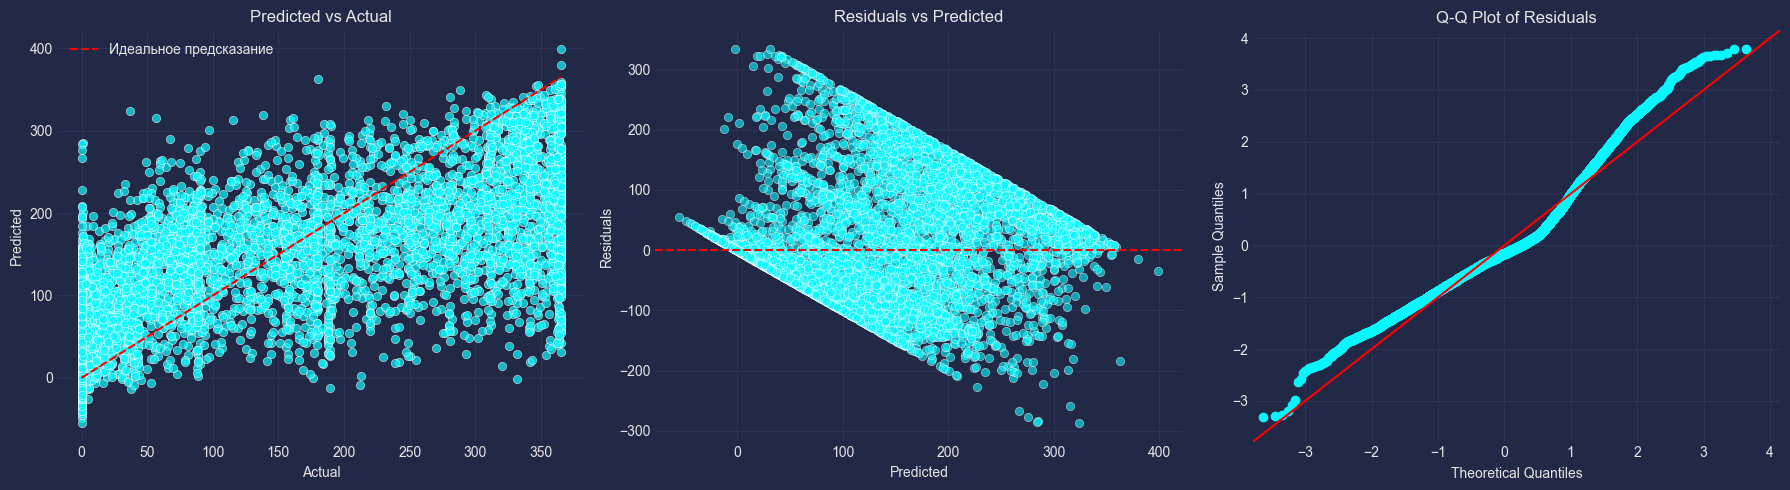

In [28]:
evaluate_model(model_final)

## Оптимизация гиперпараметров с помощью `Optuna`

In [29]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 1500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'cat_features': cat_features,
        'random_state': 42,
        'verbose': 0
    }
    
    model_1 = CatBoostRegressor(**params)
    model_1.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=20, verbose=False)
    preds = model_1.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, show_progress_bar=True)
print('Best hyperparameters:', study.best_params)

best_params = study.best_params
best_params['loss_function'] = 'RMSE'
best_params['eval_metric'] = 'RMSE'
best_params['cat_features'] = cat_features
best_params['random_state'] = 42
best_params['verbose'] = 0

model_final_1 = CatBoostRegressor(**best_params)
model_final_1.fit(X, y)

[I 2025-03-29 22:48:04,016] A new study created in memory with name: no-name-b7c11ec2-ce34-4f4e-bc42-bb5db88a0e6d


  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 22:51:35,596] Trial 0 finished with value: 9821.290339921929 and parameters: {'iterations': 906, 'depth': 10, 'learning_rate': 0.05852137877963046, 'l2_leaf_reg': 8.547651801063955, 'bagging_temperature': 0.8675130902575131}. Best is trial 0 with value: 9821.290339921929.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 22:53:17,312] Trial 1 finished with value: 10207.687010616535 and parameters: {'iterations': 688, 'depth': 5, 'learning_rate': 0.02671682006997372, 'l2_leaf_reg': 1.0486065353264606, 'bagging_temperature': 0.76902307658823}. Best is trial 0 with value: 9821.290339921929.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 22:55:24,664] Trial 2 finished with value: 10301.72859431696 and parameters: {'iterations': 447, 'depth': 9, 'learning_rate': 0.016994327245017374, 'l2_leaf_reg': 2.8104998002614856, 'bagging_temperature': 0.054271432550310306}. Best is trial 0 with value: 9821.290339921929.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:00:29,781] Trial 3 finished with value: 9923.255437333415 and parameters: {'iterations': 935, 'depth': 10, 'learning_rate': 0.020815466490885285, 'l2_leaf_reg': 9.882689443836274, 'bagging_temperature': 0.2555104406189629}. Best is trial 0 with value: 9821.290339921929.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:03:04,526] Trial 4 finished with value: 10050.574786313266 and parameters: {'iterations': 1245, 'depth': 4, 'learning_rate': 0.034708367371605056, 'l2_leaf_reg': 6.900244077362925, 'bagging_temperature': 0.12297852445373425}. Best is trial 0 with value: 9821.290339921929.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:05:08,433] Trial 5 finished with value: 9942.012250628943 and parameters: {'iterations': 782, 'depth': 5, 'learning_rate': 0.07926270803915711, 'l2_leaf_reg': 9.786892511455216, 'bagging_temperature': 0.4448389790952597}. Best is trial 0 with value: 9821.290339921929.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:07:59,826] Trial 6 finished with value: 9866.763998983437 and parameters: {'iterations': 1203, 'depth': 8, 'learning_rate': 0.055969647508095265, 'l2_leaf_reg': 7.925203882741393, 'bagging_temperature': 0.3343636344971913}. Best is trial 0 with value: 9821.290339921929.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:09:19,586] Trial 7 finished with value: 10289.030999681223 and parameters: {'iterations': 628, 'depth': 5, 'learning_rate': 0.024804566678081508, 'l2_leaf_reg': 2.16435550344732, 'bagging_temperature': 0.05795180669917588}. Best is trial 0 with value: 9821.290339921929.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:12:10,067] Trial 8 finished with value: 9935.318633375042 and parameters: {'iterations': 1448, 'depth': 5, 'learning_rate': 0.0418500110226905, 'l2_leaf_reg': 5.6416173680492125, 'bagging_temperature': 0.5378743979878162}. Best is trial 0 with value: 9821.290339921929.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:14:51,346] Trial 9 finished with value: 10286.450587664123 and parameters: {'iterations': 1484, 'depth': 4, 'learning_rate': 0.01346159003367415, 'l2_leaf_reg': 4.517081206600886, 'bagging_temperature': 0.7310726764476604}. Best is trial 0 with value: 9821.290339921929.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:17:01,529] Trial 10 finished with value: 9837.934928852594 and parameters: {'iterations': 1026, 'depth': 7, 'learning_rate': 0.0982068140257004, 'l2_leaf_reg': 8.14859086632503, 'bagging_temperature': 0.9782458940461287}. Best is trial 0 with value: 9821.290339921929.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:18:49,711] Trial 11 finished with value: 9829.956595598242 and parameters: {'iterations': 1003, 'depth': 7, 'learning_rate': 0.0991760880443041, 'l2_leaf_reg': 7.992784999195988, 'bagging_temperature': 0.9785339766625998}. Best is trial 0 with value: 9821.290339921929.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:22:01,088] Trial 12 finished with value: 9863.66345860176 and parameters: {'iterations': 1076, 'depth': 7, 'learning_rate': 0.061823824646144276, 'l2_leaf_reg': 8.137275037924207, 'bagging_temperature': 0.9914882222480518}. Best is trial 0 with value: 9821.290339921929.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:23:50,708] Trial 13 finished with value: 9838.51998512649 and parameters: {'iterations': 836, 'depth': 8, 'learning_rate': 0.09826917846276066, 'l2_leaf_reg': 6.645121314867197, 'bagging_temperature': 0.8167408803818246}. Best is trial 0 with value: 9821.290339921929.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:25:36,346] Trial 14 finished with value: 9959.406909480156 and parameters: {'iterations': 321, 'depth': 10, 'learning_rate': 0.057740393737984855, 'l2_leaf_reg': 9.146484549169983, 'bagging_temperature': 0.6282794650099999}. Best is trial 0 with value: 9821.290339921929.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:29:48,586] Trial 15 finished with value: 9818.486312906613 and parameters: {'iterations': 1158, 'depth': 8, 'learning_rate': 0.043797325891882136, 'l2_leaf_reg': 6.704026377194387, 'bagging_temperature': 0.8763278011765625}. Best is trial 15 with value: 9818.486312906613.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:33:39,580] Trial 16 finished with value: 9830.312750489978 and parameters: {'iterations': 1236, 'depth': 9, 'learning_rate': 0.041646305635763256, 'l2_leaf_reg': 4.683118617607026, 'bagging_temperature': 0.8375580733161725}. Best is trial 15 with value: 9818.486312906613.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:37:55,273] Trial 17 finished with value: 9814.557443597547 and parameters: {'iterations': 1118, 'depth': 9, 'learning_rate': 0.04437477058299195, 'l2_leaf_reg': 6.4552745672215055, 'bagging_temperature': 0.6638019926266248}. Best is trial 17 with value: 9814.557443597547.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:43:13,374] Trial 18 finished with value: 10086.639452227884 and parameters: {'iterations': 1350, 'depth': 8, 'learning_rate': 0.010192823144936093, 'l2_leaf_reg': 6.238639169289128, 'bagging_temperature': 0.6520223048658711}. Best is trial 17 with value: 9814.557443597547.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:47:14,976] Trial 19 finished with value: 9824.004098373885 and parameters: {'iterations': 1144, 'depth': 9, 'learning_rate': 0.04203578354768925, 'l2_leaf_reg': 4.71887986055976, 'bagging_temperature': 0.5164436215930686}. Best is trial 17 with value: 9814.557443597547.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:51:06,039] Trial 20 finished with value: 9916.785995135424 and parameters: {'iterations': 1329, 'depth': 6, 'learning_rate': 0.03020568073628733, 'l2_leaf_reg': 3.604437365804691, 'bagging_temperature': 0.6463751101479244}. Best is trial 17 with value: 9814.557443597547.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:54:52,312] Trial 21 finished with value: 9846.070304556566 and parameters: {'iterations': 902, 'depth': 10, 'learning_rate': 0.04979665545555702, 'l2_leaf_reg': 7.108528923212589, 'bagging_temperature': 0.8679837249604738}. Best is trial 17 with value: 9814.557443597547.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-29 23:57:09,313] Trial 22 finished with value: 9914.85174159514 and parameters: {'iterations': 1127, 'depth': 9, 'learning_rate': 0.07253858592878898, 'l2_leaf_reg': 8.882098288179542, 'bagging_temperature': 0.7133551487013948}. Best is trial 17 with value: 9814.557443597547.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-30 00:00:02,342] Trial 23 finished with value: 9934.779404965211 and parameters: {'iterations': 724, 'depth': 8, 'learning_rate': 0.037258285838675145, 'l2_leaf_reg': 5.745113138027039, 'bagging_temperature': 0.877538066046816}. Best is trial 17 with value: 9814.557443597547.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-30 00:03:49,902] Trial 24 finished with value: 9881.68823296246 and parameters: {'iterations': 984, 'depth': 10, 'learning_rate': 0.048933184441262545, 'l2_leaf_reg': 7.400441627644973, 'bagging_temperature': 0.9058720565468485}. Best is trial 17 with value: 9814.557443597547.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-30 00:06:44,671] Trial 25 finished with value: 9837.78291849748 and parameters: {'iterations': 834, 'depth': 9, 'learning_rate': 0.07078141272852448, 'l2_leaf_reg': 8.917010843287047, 'bagging_temperature': 0.6019297983669368}. Best is trial 17 with value: 9814.557443597547.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-30 00:10:32,021] Trial 26 finished with value: 9807.991368051651 and parameters: {'iterations': 1331, 'depth': 8, 'learning_rate': 0.04870758842740312, 'l2_leaf_reg': 6.225507451927571, 'bagging_temperature': 0.7623583260261739}. Best is trial 26 with value: 9807.991368051651.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-30 00:15:06,327] Trial 27 finished with value: 9837.097217742908 and parameters: {'iterations': 1360, 'depth': 8, 'learning_rate': 0.030681532414596608, 'l2_leaf_reg': 5.1161994431271385, 'bagging_temperature': 0.7641408141594471}. Best is trial 26 with value: 9807.991368051651.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-30 00:18:07,637] Trial 28 finished with value: 9875.63580890603 and parameters: {'iterations': 1303, 'depth': 6, 'learning_rate': 0.0480414773907822, 'l2_leaf_reg': 6.024335008446751, 'bagging_temperature': 0.6987848525641356}. Best is trial 26 with value: 9807.991368051651.


C:\Users\MSI\AppData\Local\Temp\ipykernel_22948\3236785586.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[I 2025-03-30 00:21:15,338] Trial 29 finished with value: 9893.908382516185 and parameters: {'iterations': 1096, 'depth': 6, 'learning_rate': 0.0361153334494317, 'l2_leaf_reg': 4.020314974960694, 'bagging_temperature': 0.4687650631238967}. Best is trial 26 with value: 9807.991368051651.
Best hyperparameters: {'iterations': 1331, 'depth': 8, 'learning_rate': 0.04870758842740312, 'l2_leaf_reg': 6.225507451927571, 'bagging_temperature': 0.7623583260261739}


In [30]:
test_preds = model_final_1.predict(test)
test_ids = test.index

# Формирование DataFrame
submission_1 = pd.DataFrame({
    'index': test_ids,        
    'prediction': test_preds    
})

# Сохранение файла submission
submission_1.to_csv("submission_1.csv", index=False)

### Визуализация результатов

Метрики:
RMSE: 82.4339
MSE : 6795.3520
R²  : 0.6134


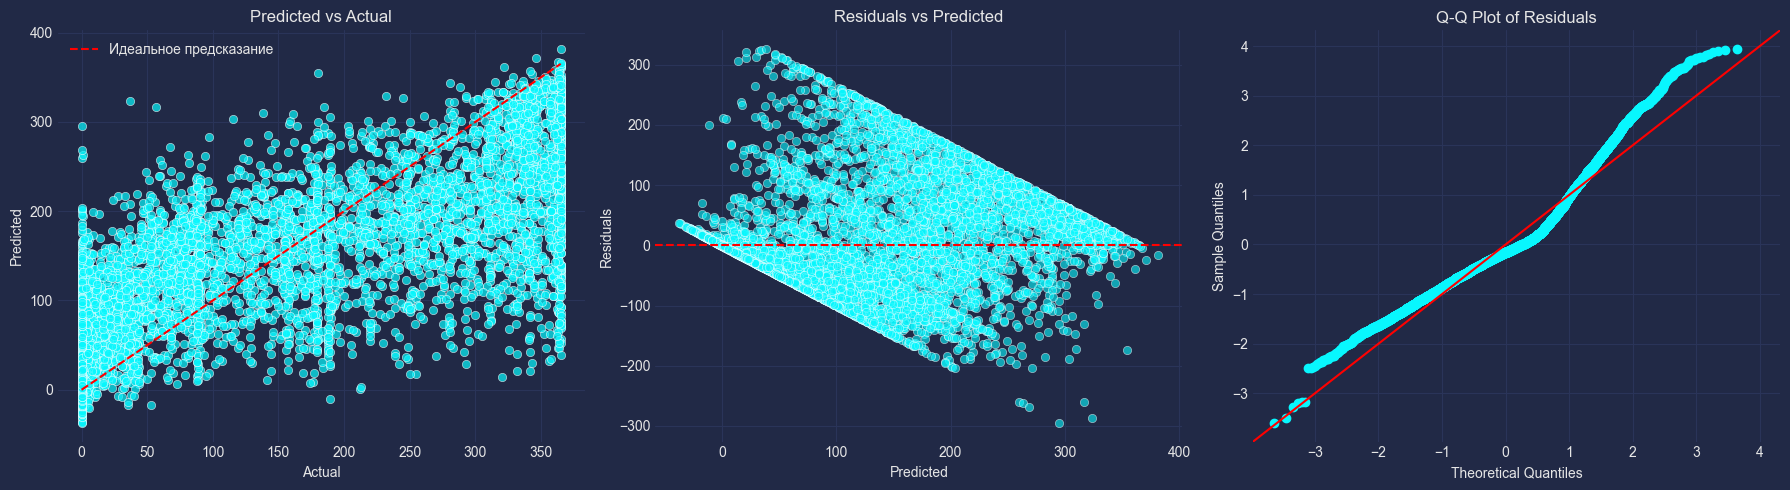

In [31]:
evaluate_model(model_final_1)

**Это те значения гиперпараметров, с которыми 2 лучших субмита перед закрытием контеста, модели с ними построены дальше**

### Модель 1 из Optuna - вторая в контесте

In [32]:
model_final_2 = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    cat_features=cat_features,
    random_state=42,
    iterations=1268,
    learning_rate=0.022437792731390068,
    depth=9,
    verbose=0,
    l2_leaf_reg = 8.129170491609113,
    bagging_temperature = 0.8148122505587146
)

model_final_2.fit(X, y)

In [33]:
test_preds = model_final_2.predict(test)
test_ids = test.index

# Формирование DataFrame
submission_2 = pd.DataFrame({
    'index': test_ids,         
    'prediction': test_preds   
})

# Сохранение файла submission
submission_2.to_csv("submission_2.csv", index=False)

### Визуализация результатов

Метрики:
RMSE: 86.0516
MSE : 7404.8744
R²  : 0.5787


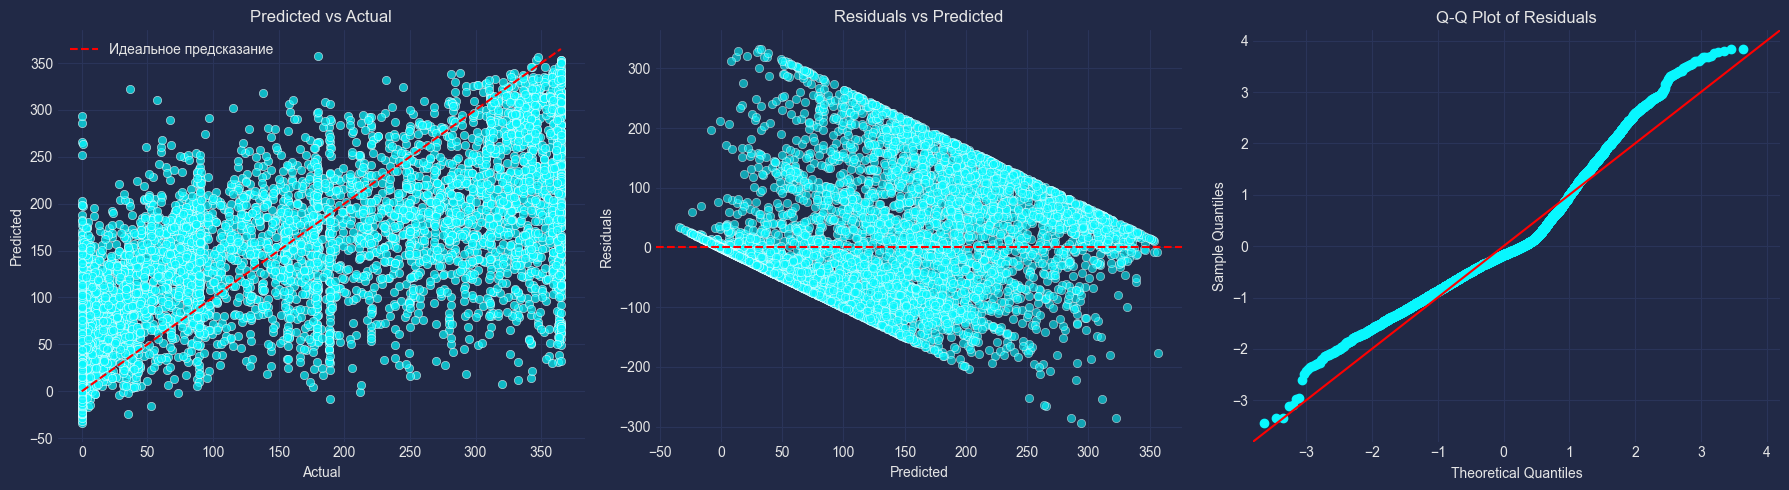

In [34]:
evaluate_model(model_final_2)

### Модель 2 из Optuna - самая оптимальная из контеста

In [35]:
model_final_3 = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    cat_features=cat_features,
    random_state=42,
    iterations=1456,
    learning_rate=0.06674887181215822,
    depth=9,
    verbose=0,
    l2_leaf_reg = 5.957106624881745,
    bagging_temperature = 0.39952894574802333
)

model_final_3.fit(X, y)

In [36]:
test_preds = model_final_3.predict(test)
test_ids = test.index

# Формирование DataFrame
submission_3 = pd.DataFrame({
    'index': test_ids,         
    'prediction': test_preds    
})

# Сохранение файла submission
submission_3.to_csv("submission_3.csv", index=False)

### Визуализация результатов

Метрики:
RMSE: 76.1909
MSE : 5805.0524
R²  : 0.6697


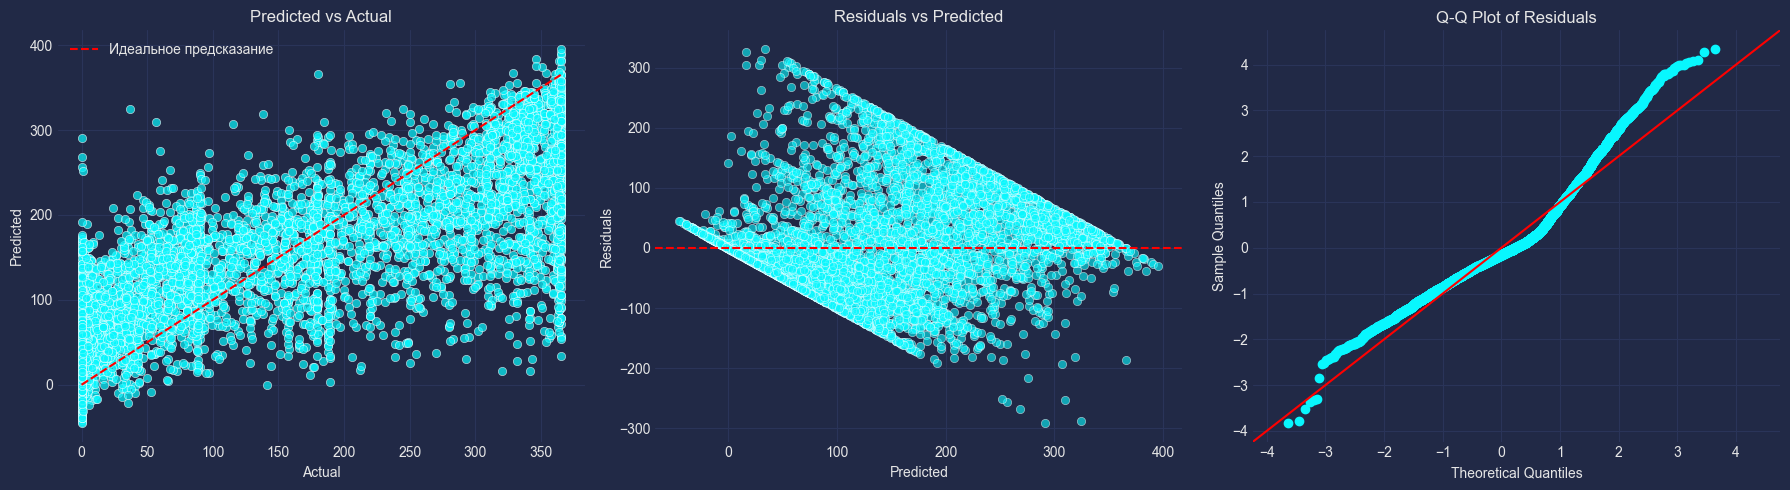

In [37]:
evaluate_model(model_final_3)

## Что пробовалось

- Были обучены модели с различными комбинациями параметров (в том числе глубина деревьев, количество итераций и l2-регуляризация).
- Пробовали модели без и с логарифмированием целевой переменной, во втором варианте модель вела себя лучше, так что все модели сделаны с такой обработкой.
- Разные варианты обработки данных (н-п, без добавленитя нового параметра). Стоит учесть и то, что `name` я сразу удалил и ничего с ним не делал.
- Проведен анализ важности признаков через SHAP, но не успел это как-то применить непосредственно к модели, так как времени не оставалось.

## Что могло пойти не так

- Модель `model_final_3` показала лучшую валидационную метрику, но уступила `model_final_1` на лидерборде Kaggle. Вероятно, переобучение на валидации.
- Использовалось только одно разбиение (train/test), что снижает надежность оценки. Лучше было бы, наверное, применить KFold или CV.
- Гиперпараметры подобраны ограниченно — возможно, не достигнут глобальный минимум ошибки, но пришлось бы достаточно долго ждать пока Optuna обработает все.

## Анализ с помощью `Shap`

### Первый сабмит

Анализ признаков первого сабмита я делал еще до ласт моделей, но в итоге так и не поработал с признаками, а просто поработал с настройкой гиперпараметров - так что это весомая идея для улучшения.

In [38]:
# Категориальные признаки
cat_features = X_val.select_dtypes(include='object').columns.tolist()

# Pool
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)

# SHAP-значения
shap_values = model_final.get_feature_importance(type='ShapValues', data=val_pool)
shap_values = shap_values[:, :-1]

feature_names = X_val.columns

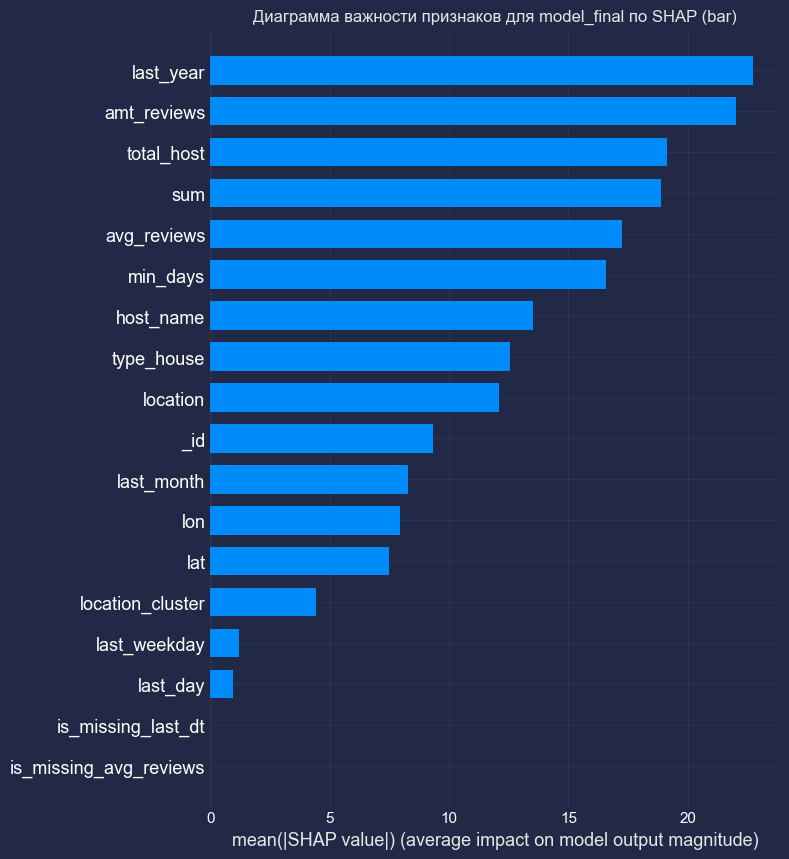

In [39]:
# Первый график — BAR
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, X_val, plot_type="bar", feature_names=feature_names, show=False)

fig = plt.gcf()
ax = plt.gca()
ax.set_title("Диаграмма важности признаков для model_final по SHAP (bar)")
for label in ax.get_yticklabels():
    label.set_color('white')
for label in ax.get_xticklabels():
    label.set_color('white')
plt.tight_layout()
plt.show()

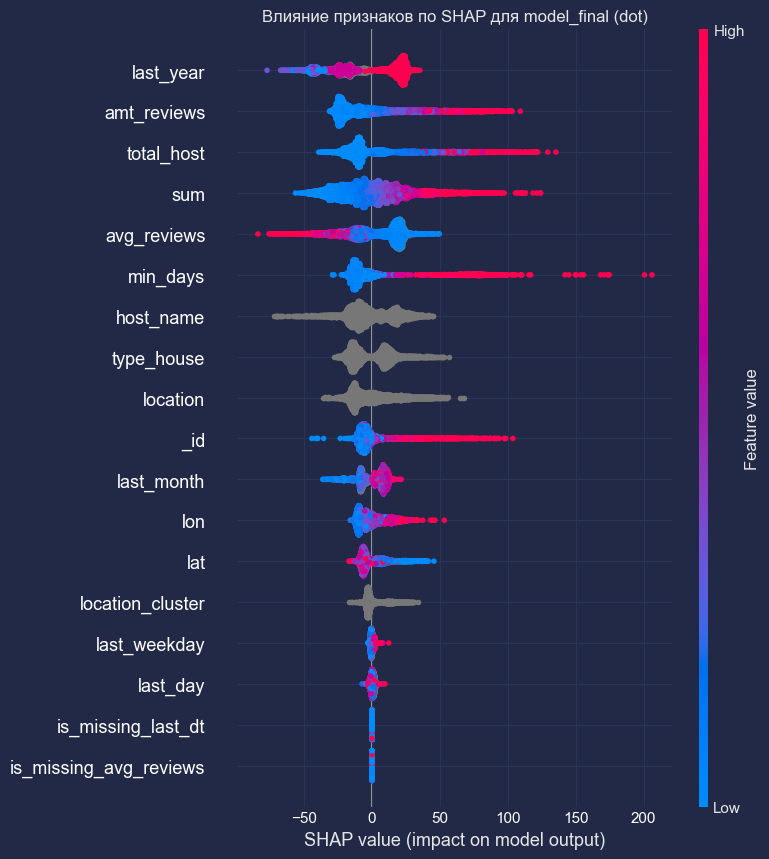

In [40]:
# Второй график — DOT
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, X_val, feature_names=feature_names, show=False)

fig = plt.gcf()
ax = plt.gca()
ax.set_title("Влияние признаков по SHAP для model_final (dot)")
for label in ax.get_yticklabels():
    label.set_color('white')
for label in ax.get_xticklabels():
    label.set_color('white')
plt.tight_layout()
plt.show()

### Самая оптимальная, но сабмит после завершения

In [41]:
# SHAP-значения
shap_values_1 = model_final_1.get_feature_importance(type='ShapValues', data=val_pool)
shap_values_1 = shap_values_1[:, :-1]

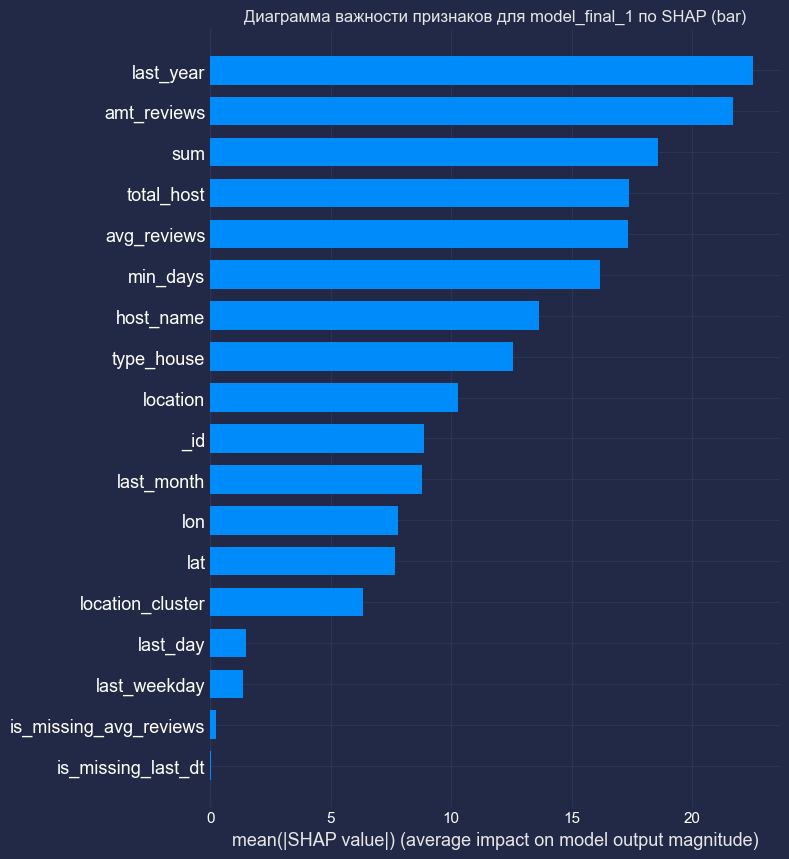

In [42]:
# Первый график — BAR
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values_1, X_val, plot_type="bar", feature_names=feature_names, show=False)

fig = plt.gcf()
ax = plt.gca()
ax.set_title("Диаграмма важности признаков для model_final_1 по SHAP (bar)")
for label in ax.get_yticklabels():
    label.set_color('white')
for label in ax.get_xticklabels():
    label.set_color('white')
plt.tight_layout()
plt.show()

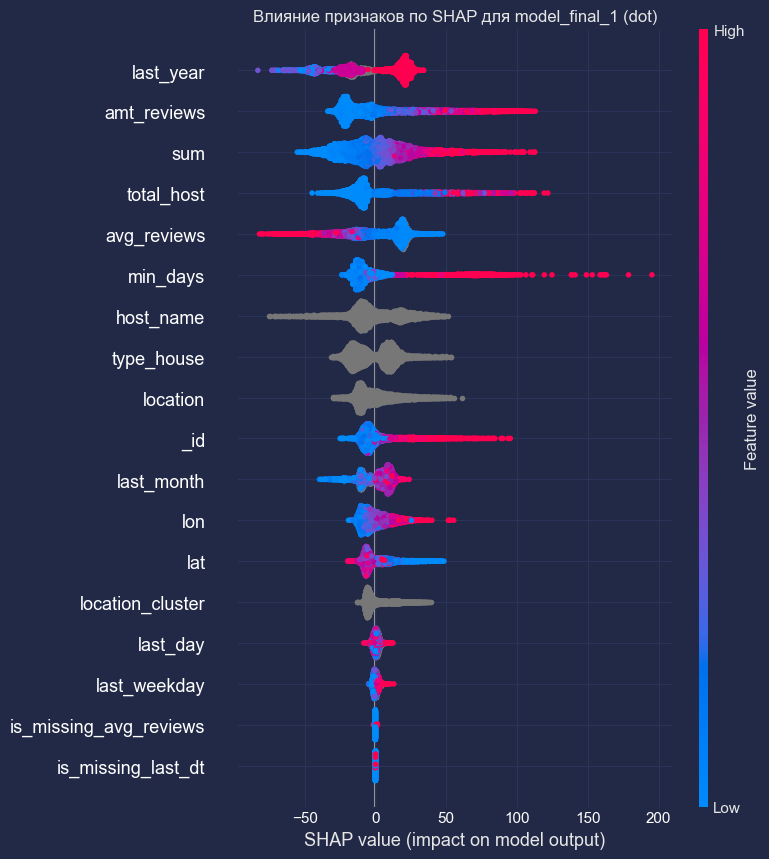

In [43]:
# Второй график — DOT
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values_1, X_val, feature_names=feature_names, show=False)

fig = plt.gcf()
ax = plt.gca()
ax.set_title("Влияние признаков по SHAP для model_final_1 (dot)")
for label in ax.get_yticklabels():
    label.set_color('white')
for label in ax.get_xticklabels():
    label.set_color('white')
plt.tight_layout()
plt.show()

### Модель с сабмитом, который в итоге значится на первом месте

In [44]:
# SHAP-значения
shap_values_3 = model_final_3.get_feature_importance(type='ShapValues', data=val_pool)
shap_values_3 = shap_values_3[:, :-1]

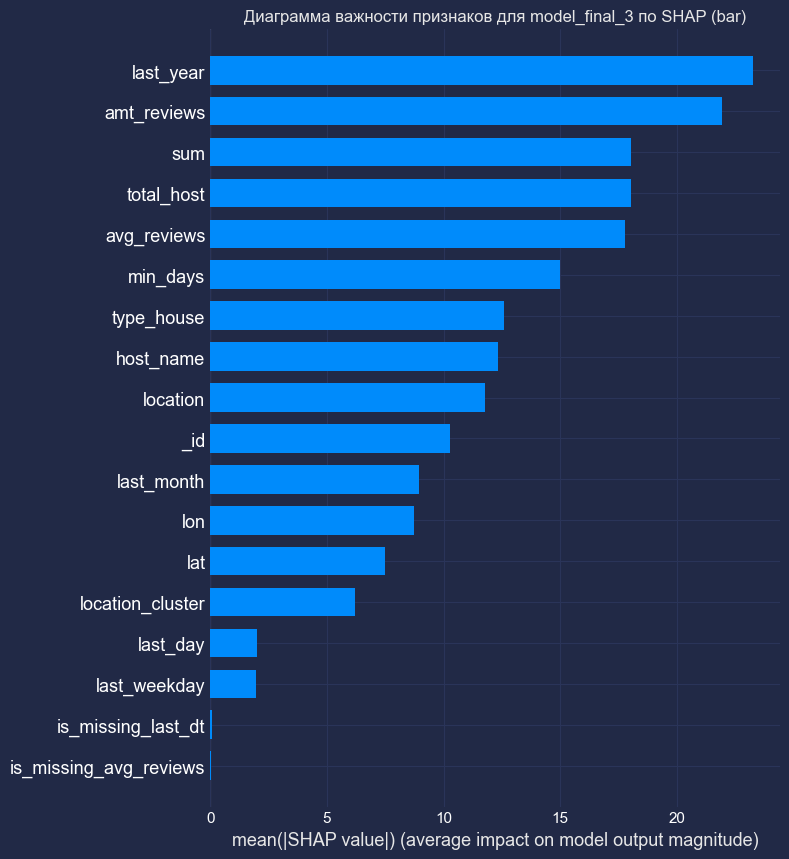

In [45]:
# Первый график — BAR
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values_3, X_val, plot_type="bar", feature_names=feature_names, show=False)

fig = plt.gcf()
ax = plt.gca()
ax.set_title("Диаграмма важности признаков для model_final_3 по SHAP (bar)")
for label in ax.get_yticklabels():
    label.set_color('white')
for label in ax.get_xticklabels():
    label.set_color('white')
plt.tight_layout()
plt.show()

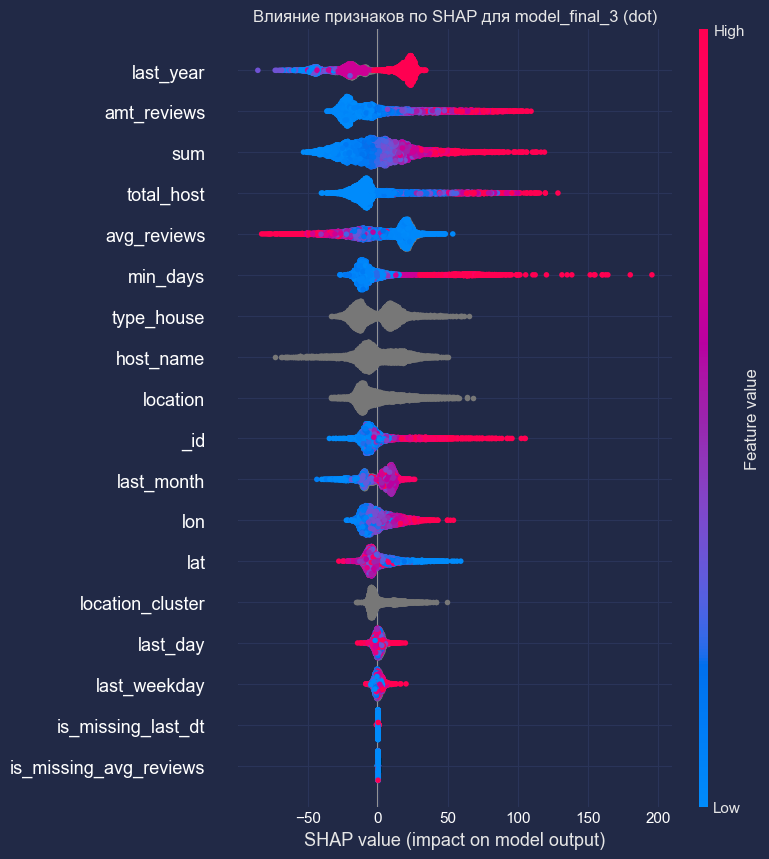

In [46]:
# Второй график — DOT
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values_3, X_val, feature_names=feature_names, show=False)

fig = plt.gcf()
ax = plt.gca()
ax.set_title("Влияние признаков по SHAP для model_final_3 (dot)")
for label in ax.get_yticklabels():
    label.set_color('white')
for label in ax.get_xticklabels():
    label.set_color('white')
plt.tight_layout()
plt.show()

В общем, созданные признаки оказались не особл информативными и полезными для модели — с эти на самом деле стоит тоже поработать.

## Применимость решения в бизнесе

Построенная модель может быть эффективно использована в реальных бизнес-процессах, связанных с управлением размещениями на платформе. Потенциальные направления применения включают:

- Прогнозирование ключевых количественных показателей — таких как предполагаемая доходность, уровень спроса или активность размещения.
- Использование интерпретируемых результатов (в частности, SHAP-значений) для аналитики и принятия управленческих решений, например — для оценки влияния параметров на результат.
- Автоматизация процессов приоритизации, сегментации объектов и формирования индивидуальных рекомендаций хостам.
- Выбранный алгоритм (CatBoost) пригоден для внедрения в продакшн-среду благодаря встроенной поддержке категориальных признаков, устойчивости к пропущенным данным и встроенному механизму борьбы с переобучением.

## Outro

### Идея №1: Использование KFold-валидации
- Что даст — уменьшит риск переобучения, обеспечит устойчивую оценку модели.
- Что нужно — заменить `train_test_split` на `KFold(n_splits=5)`.

### Идея №2: Глубокий автоматический подбор гиперпараметров
- Что даст — повысит качество предсказаний.
- Что нужно — использовать `Optuna` или `GridSearchCV` с более широким пространством поиска.

### Идея №3: Улучшение признаков
- Что даст — повысит выразительность модели.
- Что нужно — построить взаимодействия между признаками, агрегации по `host_name` и `location_cluster`, использовать частотные и целевые энкодинги. В общем, много интересных вариантов, с которыми можно поработать.